# PyTorch ST-GCN Dataset

SEOYEON CHOI  
2022-12-21

> PyTorch Geometric Temporal Dataset

https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/dataset.html#module-torch_geometric_temporal.dataset.chickenpox

[논문](https://arxiv.org/pdf/2104.07788.pdf)

\|Dataset\|Signal\|Graph\|Frequency\|𝑇\|ㅣ𝑉ㅣ \|
\|:–:\|:–:\|\|:–:\|\|:–:\| \|Chickenpox
Hungary\|Temporal\|Static\|Weekly\|522\|20\| \|Windmill
Large\|Temporal\|Static\|Hourly\|17,472\|319\| \|Windmill
Medium\|Temporal\|Static\|Hourly\|17,472\|26\| \|Windmill
Small\|Temporal\|Static\|Hourly\|17,472\|11\| \|Pedal Me
Deliveries\|Temporal\|Static\|Weekly\|36\|15\| \|Wikipedia
Math\|Temporal\|Static\|Daily\|731\|1,068\| \|Twitter Tennis
RG\|Static\|Dynamic\|Hourly\|120\|1000\| \|Twitter Tennis
UO\|Static\|Dynamic\|Hourly\|112\|1000\| \|Covid19
England\|Temporal\|Dynamic\|Daily\|61\|129\| \|Montevideo
Buses\|Temporal\|Static\|Hourly\|744\|675\| \|MTM-1 Hand
Motions\|Temporal\|Static\|1/24 Seconds\|14,469\|21\|

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch_geometric_temporal.signal import temporal_signal_split

#### RecurrentGCN

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

## ChickenpoxDatasetLoader

Chickenpox Hungary

-   A spatiotemporal dataset about the officially reported cases of
    chickenpox in Hungary. The nodes are counties and edges describe
    direct neighbourhood relationships. The dataset covers the weeks
    between 2005 and 2015 without missingness.

데이터정리

-   T = 519
-   N = 20 \# number of nodes
-   E = 102 \# edges
-   $f(v,t)$의 차원? (1,)
-   시간에 따라서 Number of nodes가 변하는지? False
-   시간에 따라서 Number of nodes가 변하는지? False
-   X: (20,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (20,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `20`

-   vertices are counties

`-`Edges : `102`

-   edges are neighbourhoods

`-` Time : `519`

-   between 2004 and 2014
-   per weeks

In [3]:
from torch_geometric_temporal.dataset import  ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=1)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [4]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [5]:
time

In [6]:
(data[0][1]).x.type,(data[0][1]).edge_index.type,(data[0][1]).edge_attr.type,(data[0][1]).y.type

In [1697]:
max((data[4][1]).x[0])

In [1668]:
G = nx.Graph()

In [1669]:
node_list = torch.tensor(range(20)).tolist()

In [1670]:
G.add_nodes_from(node_list)

In [1671]:
data[-1]

In [1672]:
len(data[0][1].edge_index[0])

In [1673]:
edge_list=[]
for i in range(519):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1674]:
G.add_edges_from(edge_list)

In [1675]:
G.number_of_nodes(),G.number_of_edges()

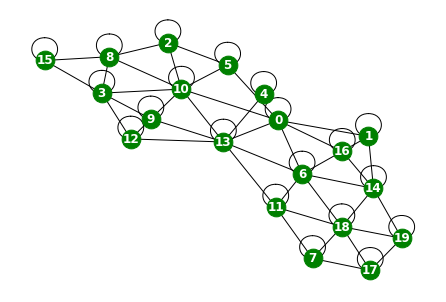

In [1677]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1559]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [216]:
from torch_geometric_temporal.dataset import  ChickenpoxDatasetLoader
loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [21]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [37]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [34]:
(data[1][1]).x[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [35]:
(data[2][1]).x[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 20개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{20}\}, t=1,2,\dots,519$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [217]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]

In [218]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [219]:
_x.shape

In [220]:
_edge_index.shape

In [221]:
_edge_attr.shape

In [222]:
_y.shape

In [223]:
_x.shape

x

-   Vertex features are lagged weekly counts of the chickenpox cases (we
    included 4 lags). y

-   The target is the weekly number of cases for the upcoming week

In [224]:
_x

In [225]:
_y

## PedalMeDatasetLoader

Pedal Me Deliveries

-   A dataset about the number of weekly bicycle package deliveries by
    Pedal Me in London during 2020 and 2021. Nodes in the graph
    represent geographical units and edges are proximity based mutual
    adjacency relationships.

데이터정리

-   T = 33
-   V = 지역의 집합
-   N = 15 \# number of nodes
-   E = 225 \# edges
-   $f(v,t)$의 차원? (1,) \# number of deliveries
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (15,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (15,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `15`

-   vertices are localities

`-`Edges : `225`

-   edges are spatial_connections

`-` Time : `33`

-   between 2020 and 2021
-   per weeks

In [33]:
from torch_geometric_temporal.dataset import  PedalMeDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = PedalMeDatasetLoader()

dataset = loader.get_dataset(lags=1)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1561]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1541]:
time

In [1542]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1232]:
G = nx.Graph()

In [1233]:
node_list = torch.tensor(range(15)).tolist()

In [1234]:
G.add_nodes_from(node_list)

In [1235]:
data[-1]

In [1236]:
edge_list=[]
for i in range(33):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1237]:
G.add_edges_from(edge_list)

In [1238]:
G.number_of_nodes(),G.number_of_edges()

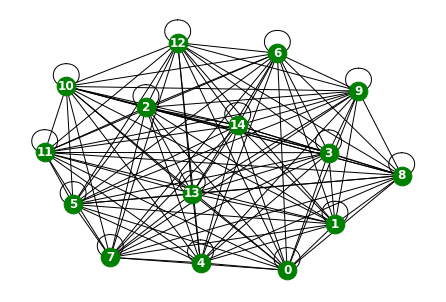

In [1239]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1562]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [226]:
from torch_geometric_temporal.dataset import  PedalMeDatasetLoader
loader = PedalMeDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [227]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [231]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [234]:
(data[1][1]).x[0], (data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [236]:
(data[2][1]).x[0], (data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 15개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{15}\}, t=1,2,\dots,33$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [26]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:03<00:00, 16.04it/s]

In [27]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [28]:
_x.shape

In [29]:
_edge_index.shape

In [30]:
_edge_attr.shape

In [31]:
_y.shape

In [32]:
_x.shape

x

-   Vertex features are lagged weekly counts of the delivery demands (we
    included 4 lags).
-   주마다 배달 수요의 수가 얼마나 될지 percentage로, t-4시점까지?

y

-   The target is the weekly number of deliveries the `upcoming` week.
    Our dataset consist of more than 30 snapshots (weeks).
-   그 다음주에 배달의 수가 몇 퍼센트로 발생할지?

In [33]:
_x[0:3]

In [34]:
_y

## WikiMathsDatasetLoader

Wikipedia Math

-   Contains Wikipedia pages about popular mathematics topics and edges
    describe the links from one page to another. Features describe the
    number of daily visits between 2019 and 2021 March.

데이터정리

-   T = 722
-   V = 위키피디아 페이지
-   N = 1068 \# number of nodes
-   E = 27079 \# edges
-   $f(v,t)$의 차원? (1,) \# 해당페이지를 유저가 방문한 횟수
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (1068,8) (N,8),
    $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3),f(v,t_4),f(v,t_5),f(v,t_6),f(v,t_7)$
-   y: (1068,) (N,), $f(v,t_8)$
-   예제코드적용가능여부: Yes

`-` Nodes : `1068`

-   vertices are Wikipedia pages

`-`Edges : `27079`

-   edges are links between them

`-` Time : `722`

-   Wikipedia pages between March 16th 2019 and March 15th 2021
-   per weeks

In [1640]:
from torch_geometric_temporal.dataset import  WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1641]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1642]:
time

In [1643]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1646]:
(data[10][1]).x

In [1616]:
G = nx.Graph()

In [1617]:
node_list = torch.tensor(range(1068)).tolist()

In [1618]:
G.add_nodes_from(node_list)

In [1247]:
edge_list=[]
for i in range(722):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1248]:
G.add_edges_from(edge_list)

In [1249]:
G.number_of_nodes(),G.number_of_edges()

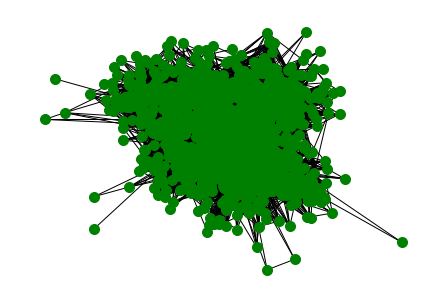

In [1250]:
nx.draw(G,node_color='green',node_size=100,width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1565]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

In [1619]:
np.where(data[11][1].edge_index != data[10][1].edge_index)

In [1620]:
np.where(data[11][1].edge_index != data[20][1].edge_index)

------------------------------------------------------------------------

https://www.kaggle.com/code/mapologo/loading-wikipedia-math-essentials

In [239]:
from torch_geometric_temporal.dataset import  WikiMathsDatasetLoader
loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=8)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [240]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [241]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3,,x_4,x_5,x_6,x_7$
-   y:= $x_9$

In [243]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8$
-   y:= $x_9$

In [245]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9$
-   y:=$x_{10}$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 1068개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7) \to (x_8)$
-   $(x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8) \to (x_9)$

$f(v,t), v \in \{v_1,\dots,v_{1068}\}, t=1,2,\dots,722$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [58]:
model = RecurrentGCN(node_features=8, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [09:28<00:00, 11.37s/it]

In [167]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [168]:
_x.shape

In [61]:
_edge_index.shape

어떤 페이지에 refer가 되었는지

In [73]:
_edge_index[0][:5],_edge_index[1][:5]

In [116]:
_edge_attr.shape

In [77]:
_edge_attr[:5]

-   Weights represent the number of links found at the source Wikipedia
    page linking to the target Wikipedia page.

가중치는 엣지별 한 페이지에 refer되었는지, 몇 번 되었나 수 나옴

In [63]:
_y.shape

In [64]:
_x.shape

x

-   lag 를 몇으로 지정하느냐에 따라 다르게 추출

y

-   The target is the daily user visits to the Wikipedia pages between
    March 16th 2019 and March 15th 2021 which results in 731 periods.
-   매일 위키피디아 해당 페이지에 몇 명의 유저가 방문하는지!
-   음수가 왜 나오지..

In [84]:
_x[0:3]

In [117]:
_y[:3]

In [ ]:
y_hat[:3].data

# Windmill Output Datasets

-   An hourly windfarm energy output dataset covering 2 years from a
    European country. Edge weights are calculated from the proximity of
    the windmills – high weights imply that two windmill stations are in
    close vicinity. The size of the dataset relates to the groupping of
    windfarms considered; the smaller datasets are more localized to a
    single region.

## WindmillOutputLargeDatasetLoader

Hourly energy output of windmills from a European country for more than
2 years. Vertices represent 319 windmills and weighted edges describe
the strength of relationships. The target variable allows for regression
tasks.

데이터정리

-   T = 17470
-   V = 풍력발전소
-   N = 319 \# number of nodes
-   E = 101761 = N^2 \# edges
-   $f(v,t)$의 차원? (1,) \# Hourly energy output
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (319,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (319,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `319`

-   vertices represent 319 windmills

`-`Edges : `101761`

-   weighted edges describe the strength of relationships.

`-` Time : `17470`

-   more than 2 years

In [1566]:
from torch_geometric_temporal.dataset import  WindmillOutputLargeDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WindmillOutputLargeDatasetLoader()

dataset = loader.get_dataset(lags=1)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1567]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1279]:
time

In [1280]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1281]:
G = nx.Graph()

In [1282]:
node_list = torch.tensor(range(319)).tolist()

In [1283]:
G.add_nodes_from(node_list)

In [1284]:
data[-1]

time이 너무 많아서 일부만 시각화함!!

In [1285]:
edge_list=[]
for i in range(1000):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1286]:
G.add_edges_from(edge_list)

In [1287]:
G.number_of_nodes(),G.number_of_edges()

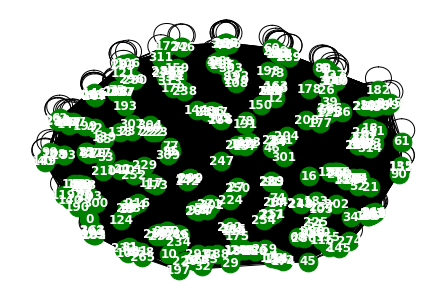

In [1288]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1568]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [246]:
from torch_geometric_temporal.dataset import  WindmillOutputLargeDatasetLoader
loader = WindmillOutputLargeDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [247]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [248]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [249]:
(data[1][1]).x[0], (data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [250]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 319개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{319}\}, t=1,2,\dots,17470$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [145]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(5)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 5/5 [1:06:03<00:00, 792.70s/it]

In [146]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [147]:
_x.shape

In [148]:
_edge_index.shape

In [149]:
_edge_attr.shape

In [150]:
_y.shape

In [151]:
_x.shape

x

-   

y

-   The target variable allows for regression tasks.

In [152]:
_x[0:3]

In [154]:
_y[0]

## WindmillOutputMediumDatasetLoader

Hourly energy output of windmills from a European country for more than
2 years. Vertices represent 26 windmills and weighted edges describe the
strength of relationships. The target variable allows for regression
tasks.

데이터정리

-   T = 17470
-   V = 풍력발전소
-   N = 319 \# number of nodes
-   E = 101761 = N^2 \# edges
-   $f(v,t)$의 차원? (1,) \# Hourly energy output
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (319,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (319,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `26`

-   vertices represent 26 windmills

`-`Edges : `225`

-   weighted edges describe the strength of relationships

`-` Time : `676`

-   more than 2 years

In [1569]:
from torch_geometric_temporal.dataset import  WindmillOutputMediumDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WindmillOutputMediumDatasetLoader()

dataset = loader.get_dataset(lags=1)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1570]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1319]:
time

In [1320]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1321]:
G = nx.Graph()

In [1322]:
node_list = torch.tensor(range(26)).tolist()

In [1323]:
G.add_nodes_from(node_list)

In [1324]:
data[-1]

In [1325]:
edge_list=[]
for i in range(17463):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1326]:
G.add_edges_from(edge_list)

In [1327]:
G.number_of_nodes(),G.number_of_edges()

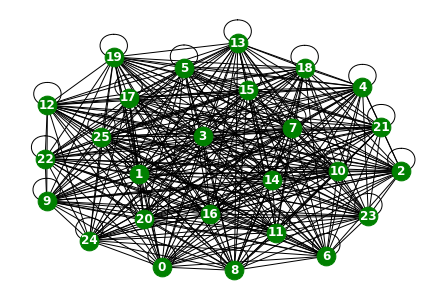

In [1328]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1571]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [251]:
from torch_geometric_temporal.dataset import  WindmillOutputMediumDatasetLoader
loader = WindmillOutputMediumDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [252]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [253]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [254]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [255]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 26개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{26}\}, t=1,2,\dots,177470$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [161]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(5)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 5/5 [03:23<00:00, 40.73s/it]

In [162]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [163]:
_x.shape

In [164]:
_edge_index.shape

In [165]:
_edge_attr.shape

In [166]:
_y.shape

In [167]:
_x.shape

x

-   

y

-   The target variable allows for regression tasks.

In [168]:
_x[0:3]

In [169]:
_y[0]

## WindmillOutputSmallDatasetLoader

Hourly energy output of windmills from a European country for more than
2 years. Vertices represent 11 windmills and weighted edges describe the
strength of relationships. The target variable allows for regression
tasks.

데이터정리

-   T = 17470
-   V = 풍력발전소
-   N = 11 \# number of nodes
-   E = 121 = N^2 \# edges
-   $f(v,t)$의 차원? (1,) \# Hourly energy output
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (11,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (11,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `11`

-   vertices represent 11 windmills

`-`Edges : `121`

-   weighted edges describe the strength of relationships

`-` Time : `17470`

-   more than 2 years

In [1572]:
from torch_geometric_temporal.dataset import WindmillOutputSmallDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WindmillOutputSmallDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1573]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1303]:
time

In [1304]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1305]:
data[-1]

In [1306]:
G = nx.Graph()

In [1307]:
node_list = torch.tensor(range(11)).tolist()

In [1308]:
G.add_nodes_from(node_list)

In [1313]:
edge_list=[]
for i in range(17463):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1314]:
G.add_edges_from(edge_list)

In [1315]:
G.number_of_nodes(),G.number_of_edges()

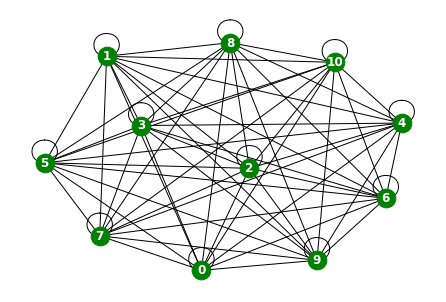

In [1316]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1574]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [256]:
from torch_geometric_temporal.dataset import WindmillOutputSmallDatasetLoader
loader = WindmillOutputSmallDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [257]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [258]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [260]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [261]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 11개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{11}\}, t=1,2,\dots,17463$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [174]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(5)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 5/5 [02:55<00:00, 35.01s/it]

In [175]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [176]:
_x.shape

In [177]:
_edge_index.shape

In [178]:
_edge_attr.shape

In [179]:
_y.shape

In [180]:
_x.shape

x

-   

y

-   The target variable allows for regression tasks.

In [181]:
_x[0:3]

In [211]:
_y

## METRLADatasetLoader_real world traffic dataset

A traffic forecasting dataset based on Los Angeles Metropolitan traffic
conditions. The dataset contains traffic readings collected from 207
loop detectors on highways in Los Angeles County in aggregated 5 minute
intervals for 4 months between March 2012 to June 2012.

데이터정리

-   T = 33
-   V = 구역
-   N = 207 \# number of nodes
-   E = 225
-   $f(v,t)$의 차원? (3,) \# Hourly energy output
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (207,4) (N,2,12),
    $x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11}$
-   y: (207,) (N,), $(x_{12})$
-   예제코드적용가능여부: No

https://arxiv.org/pdf/1707.01926.pdf

`-` Nodes : `207`

-   vertices are localities

`-`Edges : `225`

-   edges are spatial_connections

`-` Time : `33`

-   between 2020 and 2021
-   per weeks

In [1575]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = METRLADatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1576]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1331]:
time

In [1332]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1334]:
data[-1]

In [1335]:
G = nx.Graph()

In [1336]:
node_list = torch.tensor(range(20)).tolist()

In [1337]:
G.add_nodes_from(node_list)

In [1341]:
edge_list=[]
for i in range(1000):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1342]:
G.add_edges_from(edge_list)

In [1343]:
G.number_of_nodes(),G.number_of_edges()

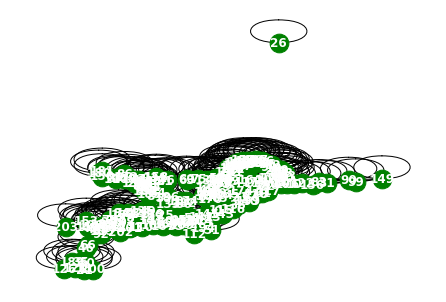

In [1345]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1577]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

논문 내용 중

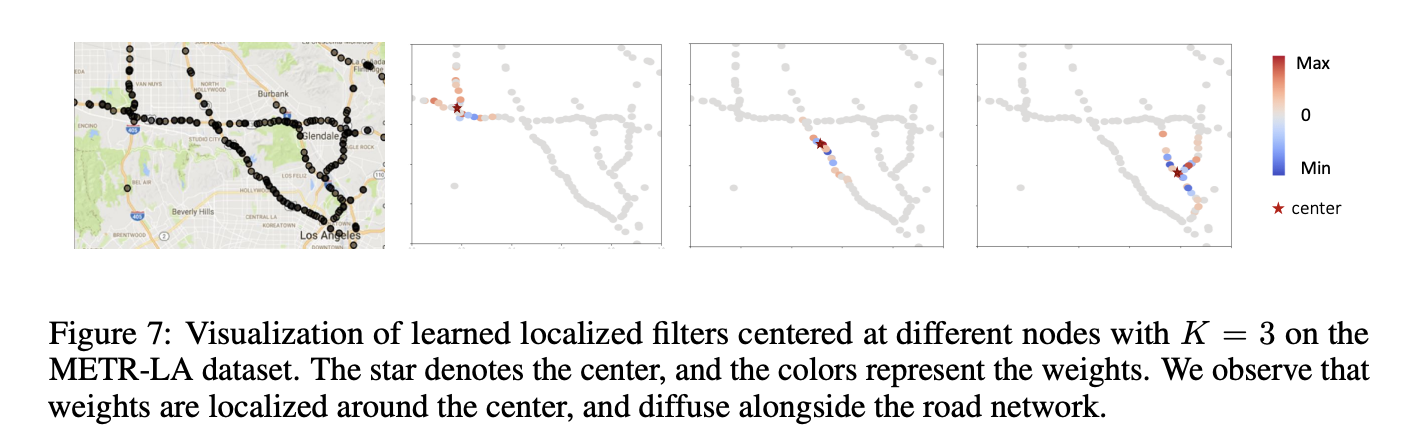

In [262]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

> **Note**
>
> `lags option 없어서 error 뜸` : get_dataset() got an unexpected
> keyword argument ‘lags’

In [263]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [264]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X,Z$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11}$
-   Z:= $z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11}$
-   y:= $x_{12}$

In [266]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},x_{12}$
-   Z:= $z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11},z_{12}$
-   y:= $x_{13}$

In [267]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:= $x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},x_{12},x_{13}$
-   Z:= $z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11},z_{12},z_{13}$
-   y:= $x_{14}$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 207개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11} \to (x_{12})$
-   $x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},x_{12},z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11},z_{12} \to (x_{13})$

$f(v,t), v \in \{v_1,\dots,v_{207}\}, t=1,2,\dots,34248$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [ ]:
model = RecurrentGCN(node_features=1, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [43]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [44]:
_x.shape

-   node 207개, traffic sensor 2개

In [45]:
_edge_index.shape

In [46]:
_edge_attr.shape

In [47]:
_y.shape

In [48]:
_x.shape

y

-   traffic speed

In [49]:
_x[0]

In [50]:
_y[0]

## PemsBayDatasetLoader

https://onlinelibrary.wiley.com/doi/pdf/10.1111/tgis.12644

A traffic forecasting dataset as described in Diffusion Convolution
Layer Paper.

This traffic dataset is collected by California Transportation Agencies
(CalTrans) Performance Measurement System (PeMS). It is represented by a
network of 325 traffic sensors in the Bay Area with 6 months of traffic
readings ranging from Jan 1st 2017 to May 31th 2017 in 5 minute
intervals.

데이터정리

-   T = 17470
-   V = 풍력발전소
-   N = 325 \# number of nodes
-   E = 101761 = N^2 \# edges
-   $f(v,t)$의 차원? (1,) \# Hourly energy output
-   시간에 따라서 N이 변하는지? False
-   시간에 따라서 E가 변하는지? False
-   X: (325,2,12) (N,2,12),
    -   $x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11}$
    -   $z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11}$
-   y: (325,) (N,2,12),
    -   $x_{13},x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23},x_{24}$
    -   $z_{13},z_{14},z_{15},z_{16},z_{17},z_{18},z_{19},z_{20},z_{21},z_{22},z_{23},z_{24}$
-   예제코드적용가능여부: No

`-` Nodes : `325`

-   vertices are sensors

`-`Edges : `2694`

-   weighted edges are between seonsor paris measured by the road
    nretwork distance

`-` Time : `52081`

-   6 months of traffic readings ranging from Jan 1st 2017 to May 31th
    2017 in 5 minute intervals

In [28]:
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = PemsBayDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [10]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [11]:
time

In [12]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [13]:
G = nx.Graph()

In [14]:
node_list = torch.tensor(range(325)).tolist()

In [15]:
data[-1]

In [16]:
G.add_nodes_from(node_list)

In [17]:
edge_list=[]
for i in range(1000):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [18]:
G.add_edges_from(edge_list)

In [19]:
G.number_of_nodes(),G.number_of_edges()

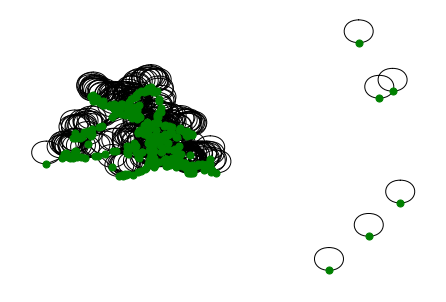

In [20]:
nx.draw(G,node_color='green',node_size=50,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1580]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [268]:
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
loader = PemsBayDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [269]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [270]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X,Z$와 $y,s$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11}$
-   Z:= $z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11}$
-   y:=
    $x_{12},x_{13},x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23}$
-   s:=
    $z_{12},z_{13},z_{14},z_{15},z_{16},z_{17},z_{18},z_{19},z_{20},z_{21},z_{22},z_{23}$

In [272]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},x_{12}$
-   Z:= $z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11},z_{12}$
-   y:=
    $x_{13},x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23},x_{24}$
-   s:=
    $z_{13},z_{14},z_{15},z_{16},z_{17},z_{18},z_{19},z_{20},z_{21},z_{22},z_{23},z_{24}$

In [273]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:= $x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},x_{12},x_{13}$
-   Z:= $z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11},z_{12},z_{13}$
-   y:=
    $x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23},x_{24},x_{25}$
-   s:=
    $z_{14},z_{15},z_{16},z_{17},z_{18},z_{19},z_{20},z_{21},z_{22},z_{23},z_{24},z_{25}$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 325개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11} \to x_{12},x_{13},x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23}$
-   $z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11} \to z_{12},z_{13},z_{14},z_{15},z_{16},z_{17},z_{18},z_{19},z_{20},z_{21},z_{22},z_{23}$
-   $x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_{10},x_{11},x_{12} \to x_{13},x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23},x_{24}$
-   $z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_{10},z_{11},z_{12} \to z_{13},z_{14},z_{15},z_{16},z_{17},z_{18},z_{19},z_{20},z_{21},z_{22},z_{23},z_{24}$

$f(v,t), v \in \{v_1,\dots,v_{325}\}, t=1,2,\dots,52081$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [ ]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [60]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [61]:
_x.shape

In [62]:
_edge_index.shape

In [63]:
_edge_attr.shape

In [64]:
_y.shape

In [65]:
_x.shape

x

-   .!

y

-   capturing temporal dependencies..?

edges connect sensors

For instance, the traffic conditions on one road on Wednesday at 3:00
p.m. are similar to the traffic conditions on Thursday at the same time.

In [66]:
_x[0:3]

In [68]:
_y[0]

## EnglandCovidDatasetLoader

Covid19 England

-   A dataset about mass mobility between regions in England and the
    number of confirmed COVID-19 cases from March to May 2020 \[38\].
    Each day contains a different mobility graph and node features
    corresponding to the number of cases in the previous days. Mobility
    stems from Facebook Data For Good 1 and cases from gov.uk 2

https://arxiv.org/pdf/2009.08388.pdf

데이터정리

-   T = 52
-   V = 지역
-   N = 129 \# number of nodes
-   E = 2158
-   $f(v,t)$의 차원? (1,) \# 코로나확진자수
-   시간에 따라서 Number of nodes가 변하는지? False
-   시간에 따라서 Number of nodes가 변하는지? False
-   X: (20,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (20,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `129`

-   vertices are correspond to the number of COVID-19 cases in the
    region in the past window days.

`-`Edges : `2158`

-   the spatial edges capture county-to-county movement at a specific
    date, and a county is connected to a number of past instances of
    itself with temporal edges.

`-` Time : `52`

-   from 3 March to 12 of May

In [1581]:
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = EnglandCovidDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1582]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1366]:
time

In [1367]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1368]:
G = nx.Graph()

In [1369]:
node_list = torch.tensor(range(129)).tolist()

In [1370]:
G.add_nodes_from(node_list)

In [1371]:
data[-1]

In [1387]:
len(data[0][1].edge_index[0])

In [1392]:
edge_list=[]
for i in range(52):
    for j in range(100):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1393]:
G.add_edges_from(edge_list)

In [1394]:
G.number_of_nodes(),G.number_of_edges()

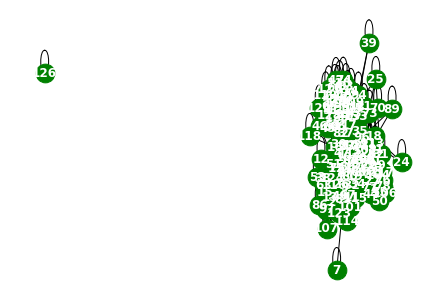

In [1396]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1590]:
np.where(data[2][1].edge_index !=data[2][1].edge_index)

------------------------------------------------------------------------

In [274]:
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
loader = EnglandCovidDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [275]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [276]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [279]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [280]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 129개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{129}\}, t=1,2,\dots,52$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [81]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:07<00:00,  6.30it/s]

In [82]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [83]:
_x.shape

In [84]:
_edge_index.shape

In [85]:
_edge_attr.shape

In [86]:
_y.shape

In [97]:
y_hat.shape

In [87]:
_x.shape

x

-   

y

-   

The node features correspond to the number of COVID-19 cases in the
region in the past window days.

The task is to predict the number of cases in each node after 1 day

In [88]:
_x[0:3]

In [90]:
_y[:3]

## MontevideoBusDatasetLoader

https://www.fing.edu.uy/~renzom/msc/uploads/msc-thesis.pdf

Montevideo Buses

-   A dataset about the hourly passenger inflow at bus stop level for
    eleven bus lines from the city of Montevideo. Nodes are bus stops
    and edges represent connections between the stops; the dataset
    covers a whole month of traffic patterns.

데이터정리

-   T = 739
-   V = 버스정류장
-   N = 675 \# number of nodes
-   E = 101761 = N^2 \# edges
-   $f(v,t)$의 차원? (1,) \# passenger inflow
-   시간에 따라서 Number of nodes가 변하는지? False
-   시간에 따라서 Number of nodes가 변하는지? False
-   X: (675,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
-   y: (675,,) (N,), $f(v,t_4)$
-   예제코드적용가능여부: Yes

`-` Nodes : `675`

-   vertices are bus stops

`-`Edges : `690`

-   edges are links between bus stops when a bus line connects them and
    the weight represent the road distance

`-` Time : `739`

-   hourly inflow passenger data at bus stop level for 11 bus lines
    during October 2020 from Montevideo city (Uruguay).

In [1591]:
from torch_geometric_temporal.dataset import MontevideoBusDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = MontevideoBusDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1592]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1399]:
time

In [1400]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1401]:
G = nx.Graph()

In [1402]:
node_list = torch.tensor(range(675)).tolist()

In [1403]:
G.add_nodes_from(node_list)

In [1404]:
edge_list=[]
for i in range(739):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1405]:
G.add_edges_from(edge_list)

In [1406]:
G.number_of_nodes(),G.number_of_edges()

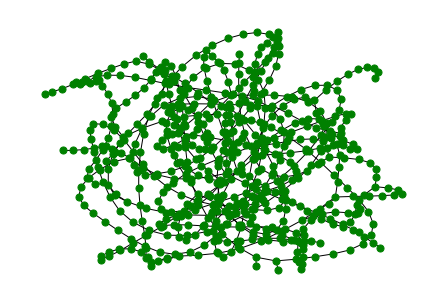

In [1410]:
nx.draw(G,node_color='green',node_size=50,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1593]:
np.where(data[0][1].edge_index != data[10][1].edge_index)

------------------------------------------------------------------------

In [281]:
from torch_geometric_temporal.dataset import MontevideoBusDatasetLoader
loader = MontevideoBusDatasetLoader()

dataset = loader.get_dataset(lags=4)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [282]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [283]:
(data[0][1]).x[0], (data[0][1]).y[0]

$t=0$에서 $X$와 $y$를 정리하면 아래와 같음.

-   X:= $x_0,x_1,x_2,x_3$
-   y:= $x_4$

In [284]:
(data[1][1]).x[0],(data[1][1]).y[0]

-   X:= $x_1,x_2,x_3,x_4$
-   y:= $x_5$

In [285]:
(data[2][1]).x[0],(data[2][1]).y[0]

-   X:=$x_2,x_3,x_4,x_5$
-   y:=$x_6$

하나의 노드에 길이가 $T$인 시계열이 맵핑되어 있음. (노드는 총 675개)

각 노드마다 아래와 같은 과정으로 예측이 됨

-   $(x_0,x_1,x_2,x_3) \to (x_4)$
-   $(x_1,x_2,x_3,x_4) \to (x_5)$

$f(v,t), v \in \{v_1,\dots,v_{675}\}, t=1,2,\dots,739$

$${\bf X}_{t=1} = \begin{bmatrix} 
f(v_1,t=1) & f(v_1,t=2) & f(v_1,t=3)&  f(v_1,t=4) \\ 
f(v_2,t=1) & f(v_2,t=2) & f(v_2,t=3)&  f(v_2,t=4) \\ 
\dots & \dots  & \dots & \dots  \\ 
f(v_{20},t=1) & f(v_{20},t=2) & f(v_{20},t=3)&  f(v_{20},t=4) 
\end{bmatrix}$$

$${\bf y}_{t=1} = \begin{bmatrix} 
f(v_1,t=5) \\ 
f(v_2,t=5) \\ 
\dots  \\ 
f(v_{20},t=5) 
\end{bmatrix}$$

#### Learn

In [99]:
model = RecurrentGCN(node_features=4, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [01:51<00:00,  2.23s/it]

In [100]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [101]:
_x.shape

In [102]:
_edge_index.shape

In [103]:
_edge_attr.shape

In [104]:
_y.shape

In [105]:
_x.shape

x

-   

y

-   The target is the passenger inflow.
-   This is a curated dataset made from different data sources of the
    Metropolitan Transportation System (STM) of Montevide

In [106]:
_x[0:3]

In [109]:
_y[:3]

## TwitterTennisDatasetLoader

https://appliednetsci.springeropen.com/articles/10.1007/s41109-018-0080-5?ref=https://githubhelp.com

Twitter Tennis RG and UO

-   Twitter mention graphs of major tennis tournaments from 2017. Each
    snapshot contains the graph of popular player or sport news accounts
    and mentions between them \[5, 6\]. Node labels encode the number of
    mentions received and vertex features are structural properties

데이터정리

-   T = 52081
-   V = 트위터계정  
-   N = 1000 \# number of nodes
-   E = 119 = N^2 \# edges
-   $f(v,t)$의 차원? (1,) \# passenger inflow
-   시간에 따라서 N이 변하는지? ??
-   시간에 따라서 E가 변하는지? True
-   X: ?
-   y: ?
-   예제코드적용가능여부: No

`-` Nodes : `1000`

-   vertices are Twitter accounts

`-`Edges : `119`

-   edges are mentions between them

`-` Time : `52081`

-   Twitter mention graphs related to major tennis tournaments from 2017

In [1621]:
from torch_geometric_temporal.dataset import TwitterTennisDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = TwitterTennisDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1622]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1623]:
time

In [1624]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1630]:
data[0][1].x[0]

In [1631]:
data[0][1].edge_index[0]

In [1633]:
data[0][1].edge_attr

In [1438]:
G = nx.Graph()

In [1439]:
node_list = torch.tensor(range(1000)).tolist()

In [1440]:
G.add_nodes_from(node_list)

In [1441]:
edge_list=[]
for i in range(119):
    for j in range(40):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1442]:
G.add_edges_from(edge_list)

In [1443]:
G.number_of_nodes(),G.number_of_edges()

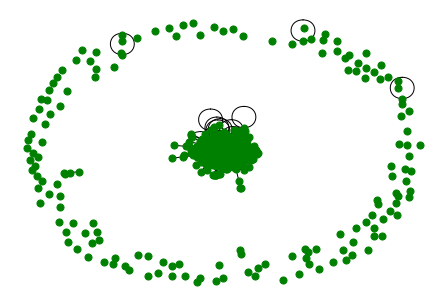

In [1444]:
nx.draw(G,node_color='green',node_size=50,width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1603]:
len(data[2][1].edge_index[0])

In [1606]:
len(data[0][1].edge_index[0])

다름..

------------------------------------------------------------------------

In [296]:
from torch_geometric_temporal.dataset import TwitterTennisDatasetLoader
loader = TwitterTennisDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [297]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [298]:
(data[0][1]).x[0], (data[0][1]).y[0]

In [299]:
(data[1][1]).x[0],(data[1][1]).y[0]

In [300]:
(data[2][1]).x[0],(data[2][1]).y[0]

In [301]:
(data[3][1]).x[0],(data[3][1]).y[0]

In [117]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [118]:
_x.shape

In [119]:
_edge_index.shape

In [120]:
_edge_attr.shape

In [121]:
_y.shape

In [122]:
_x.shape

x

-   

y

-

In [123]:
_x[0:3]

In [125]:
_y[0]

## MTMDatasetLoader

MTM-1 Hand Motions

-   A temporal dataset of MethodsTime Measurement-1 \[36\] motions,
    signalled as consecutive graph frames of 21 3D hand key points that
    were acquired via MediaPipe Hands \[64\] from original RGB-Video
    material. Node features encode the normalized xyz-coordinates of
    each finger joint and the vertices are connected according to the
    human hand structure.

데이터정리

-   T = 14452
-   V = 손의 shape에 대응하는 dot  
-   N = 325 \# number of nodes
-   E = 19 = N^2 \# edges
-   $f(v,t)$의 차원? (Grasp, Release, Move, Reach, Poision, -1)
-   시간에 따라서 N이 변하는지? ??
-   시간에 따라서 E가 변하는지? ??
-   X: ?
-   y: ?
-   예제코드적용가능여부: No

`-` Nodes : `325`

-   vertices are are the finger joints of the human hand

`-`Edges : `19`

-   edges are the bones connecting them

`-` Time : `14452`

In [1607]:
from torch_geometric_temporal.dataset import MTMDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = MTMDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=1)

In [1608]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [1609]:
time

In [1448]:
(data[0][1]).x.shape,(data[0][1]).edge_index.shape,(data[0][1]).edge_attr.shape

In [1449]:
G = nx.Graph()

In [1450]:
node_list = torch.tensor(range(21)).tolist()

In [1451]:
G.add_nodes_from(node_list)

In [1453]:
edge_list=[]
for i in range(14452):
    for j in range(len(data[0][1].edge_index[0])):
        edge_list.append([data[i][1].edge_index[0][j].tolist(),data[i][1].edge_index[1][j].tolist()])

In [1454]:
G.add_edges_from(edge_list)

In [1455]:
G.number_of_nodes(),G.number_of_edges()

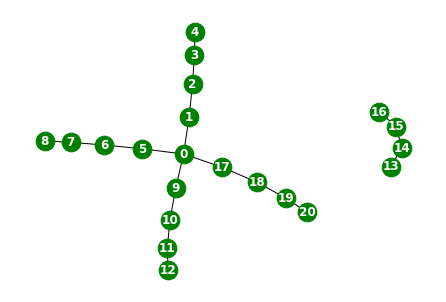

In [1457]:
nx.draw(G,with_labels=True,font_weight='bold',node_color='green',node_size=350,font_color='white',width=1)

------------------------------------------------------------------------

time별 같은 edge 정보를 가지고 있나 확인

In [1611]:
np.where(data[0][1].edge_index != data[12][1].edge_index)

------------------------------------------------------------------------

In [303]:
from torch_geometric_temporal.dataset import MTMDatasetLoader
loader = MTMDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [304]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [305]:
(data[0][1]).x[0], (data[0][1]).y[0]

In [306]:
(data[1][1]).x[0],(data[1][1]).y[0]

In [129]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [130]:
_x.shape

In [131]:
_edge_index.shape

In [132]:
_edge_attr.shape

In [133]:
_y.shape

In [134]:
_x.shape

x

-   The data x is returned in shape (3, 21, T),

y

-   The targets are manually labeled for each frame, according to one of
    the five MTM-1 motions (classes ): Grasp, Release, Move, Reach,
    Position plus a negative class for frames without graph signals (no
    hand present).
-   the target is returned one-hot-encoded in shape (T, 6).

In [143]:
_x[0]

In [137]:
_y[0]